## lightining callback

In [3]:
!python -m pip install pytorch-lightning 

In [4]:
!python -m pip install scikit-learn

In PyTorch Lightning, the four required functions you need to implement are:

1. __init__: This function initializes the model and its parameters.
2. forward: This function defines the forward pass of the model, specifying how input data is transformed into output.
3. configure_optimizers: This function sets up the optimizer(s) and learning rate scheduler(s) for training.
4. training_step: This function defines a single step of training, including how to compute the loss from the input data.

In [18]:
import pytorch_lightning as pl
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np
import json
import os
from datetime import datetime
import base64
from io import BytesIO
from PIL import Image

class DebugLogger(pl.Callback):
    def __init__(self, save_dir='./logs'):
        super().__init__()
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
        self.metrics = []
        self.all_predictions = []
        self.all_labels = []
        self.misclassified_data = []  # Store misclassified with images

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        """Called at the end of each validation batch to collect predictions"""
        x, y = batch
        logits = pl_module(x)
        preds = torch.argmax(logits, dim=1)
        
        # Store all predictions and labels
        self.all_predictions.extend(preds.cpu().numpy().tolist())
        self.all_labels.extend(y.cpu().numpy().tolist())
        
        # Identify misclassified instances and convert to base64
        misclassified_mask = (preds != y)
        if misclassified_mask.any():
            misclassified_images = x[misclassified_mask].cpu()
            misclassified_preds = preds[misclassified_mask].cpu().numpy()
            misclassified_labels = y[misclassified_mask].cpu().numpy()
            
            for img, pred, true_label in zip(misclassified_images, misclassified_preds, misclassified_labels):
                # Convert tensor to PIL Image
                img_np = img.numpy().transpose(1, 2, 0)  # CHW to HWC
                img_np = ((img_np + 1) / 2 * 255).astype(np.uint8)  # Denormalize
                img_pil = Image.fromarray(img_np)
                
                # Convert to base64
                buffer = BytesIO()
                img_pil.save(buffer, format='PNG')
                img_base64 = base64.b64encode(buffer.getvalue()).decode()
                
                self.misclassified_data.append({
                    'image_base64': img_base64,
                    'true_label': int(true_label),
                    'predicted_label': int(pred),
                    'epoch': trainer.current_epoch
                })

    def on_train_epoch_end(self, trainer, pl_module):
        """Log metrics at the end of each epoch"""
        metrics = trainer.callback_metrics
        epoch_data = {
            'epoch': trainer.current_epoch,
            'train_loss': float(metrics.get('train_loss', 0).item() if hasattr(metrics.get('train_loss', 0), 'item') else metrics.get('train_loss', 0)),
            'val_loss': float(metrics.get('val_loss', 0).item() if hasattr(metrics.get('val_loss', 0), 'item') else metrics.get('val_loss', 0)),
            'accuracy': float(metrics.get('accuracy', 0).item() if hasattr(metrics.get('accuracy', 0), 'item') else metrics.get('accuracy', 0)),
            'num_misclassified': len([m for m in self.misclassified_data if m['epoch'] == trainer.current_epoch]),
        }
        self.metrics.append(epoch_data)
        print(f"Epoch {trainer.current_epoch}: {epoch_data}")

    def on_train_end(self, trainer, pl_module):
        """Save epoch metrics and misclassified images to a single JSON file"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Combine metrics with summary and misclassified data
        all_data = {
            'summary': {
                'timestamp': timestamp,
                'total_epochs': len(self.metrics),
                'best_accuracy': max([m['accuracy'] for m in self.metrics]) if self.metrics else 0,
                'best_epoch': max(range(len(self.metrics)), key=lambda i: self.metrics[i]['accuracy']) if self.metrics else 0,
                'final_train_loss': self.metrics[-1]['train_loss'] if self.metrics else 0,
                'final_val_loss': self.metrics[-1]['val_loss'] if self.metrics else 0,
                'total_misclassified': len(self.misclassified_data)
            },
            'epochs': self.metrics,
            'misclassified_samples': self.misclassified_data
        }
        
        # Save single consolidated JSON file
        output_file = os.path.join(self.save_dir, f'training_log_{timestamp}.json')
        with open(output_file, 'w') as f:
            json.dump(all_data, f, indent=2)
        
        print(f"\n✓ Training log saved to: {output_file}")
        print(f"\n📊 Final Summary:")
        print(f"  • Total Epochs: {all_data['summary']['total_epochs']}")
        print(f"  • Best Accuracy: {all_data['summary']['best_accuracy']:.4f} (Epoch {all_data['summary']['best_epoch']})")
        print(f"  • Final Train Loss: {all_data['summary']['final_train_loss']:.4f}")
        print(f"  • Final Val Loss: {all_data['summary']['final_val_loss']:.4f}")
        print(f"  • Total Misclassified: {all_data['summary']['total_misclassified']}")

In [19]:
# Initialize the model
model = SimpleCNN(learning_rate=0.001)

# Create the custom logger
debug_logger = DebugLogger()

# Create the trainer with max_epochs and pass data loaders
trainer = pl.Trainer(max_epochs=2, callbacks=[debug_logger], enable_progress_bar=True)

# Train the model with data loaders
trainer.fit(model, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | conv1   | Conv2d    | 896    | train | 0    
1 | conv2   | Conv2d    | 18.5 K | train | 0    
2 | conv3   | Conv2d    | 73.9 K | train | 0    
3 | pool    | MaxPool2d | 0      | train | 0    
4 | fc1     | Linear    | 524 K  | train | 0    
5 | fc2     | Linear    | 2.6 K  | train | 0    
6 | dropout | Dropout   | 0      | train | 0    
------------------------------------------------------
620 K     Trainable params
0         Non-trainable params
620 K     Total params
2.481     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 1: 100%|██████████| 1563/1563 [01:38<00:00, 15.89it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=2` reached.



✓ Training log saved to: ./logs/training_log_20260117_220731.json

📊 Final Summary:
  • Total Epochs: 2
  • Best Accuracy: 0.6907 (Epoch 1)
  • Final Train Loss: 0.6682
  • Final Val Loss: 0.8888
  • Total Misclassified: 7091
Epoch 1: 100%|██████████| 1563/1563 [01:38<00:00, 15.84it/s, v_num=1]


Based on the new data you are capturing, here are some additional metrics you might consider logging to enhance your debugging and analysis capabilities:

Overall Accuracy:

The percentage of correctly classified samples out of the total samples.
Precision, Recall, and F1 Score:

These metrics provide insights into the model's performance, especially in imbalanced datasets.
Loss Values:

Training and validation loss values for each epoch to monitor convergence.
Learning Rate:

Track the learning rate used during training, especially if using a scheduler.
Training Time:

Record the time taken for each epoch or batch to monitor performance and efficiency.
Gradient Norms:

Capture the norms of gradients to analyze if they are exploding or vanishing.
Model Weights:

Optionally log model weights at certain epochs to analyze weight changes over time.
Batch-wise Metrics:

Store metrics for each batch, such as loss and accuracy, to identify problematic batches.
Input Data Statistics:

Log statistics of input data (e.g., mean, standard deviation) to ensure data normalization is effective.
Epoch Count of Correct Predictions:

Count of correctly predicted samples for each epoch.
Class-wise Metrics:

Precision, recall, and F1 score for each class to identify specific classes that may be problematic.
Visualizations:
Save visualizations of loss curves, accuracy curves, or other relevant plots for analysis.
By capturing these additional metrics, you can gain a more comprehensive understanding of your model's performance and identify areas for improvement

## model

In [7]:
!python -m pip install torchvision

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

# Define data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

/usr/local/python/3.12.1/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Train dataset size: 50000
Val dataset size: 10000


In [9]:
# Define a simple CNN model using PyTorch Lightning
class SimpleCNN(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        
        # Convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = torch.nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = torch.nn.Linear(128 * 4 * 4, 256)
        self.fc2 = torch.nn.Linear(256, 10)
        
        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.5)
    
    def forward(self, x):
        # Conv block 1: 32 filters -> 16x16
        x = self.pool(F.relu(self.conv1(x)))
        
        # Conv block 2: 64 filters -> 8x8
        x = self.pool(F.relu(self.conv2(x)))
        
        # Conv block 3: 128 filters -> 4x4
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss)
        self.log('accuracy', acc)
        return loss

## visualize 

In [16]:
!pip install pandas
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 24.0 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 34.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


📂 Loaded: training_log_20260117_215843.json

                           TRAINING SUMMARY                           
Timestamp:        20260117_215843
Total Epochs:     2
Best Accuracy:    0.6743 (Epoch 1)
Final Train Loss: 0.7304
Final Val Loss:   0.9381

Epoch Metrics:
 epoch  train_loss  val_loss  accuracy  num_misclassified
     0    1.045938  1.113404    0.6005                315
     1    0.730447  0.938107    0.6743                313


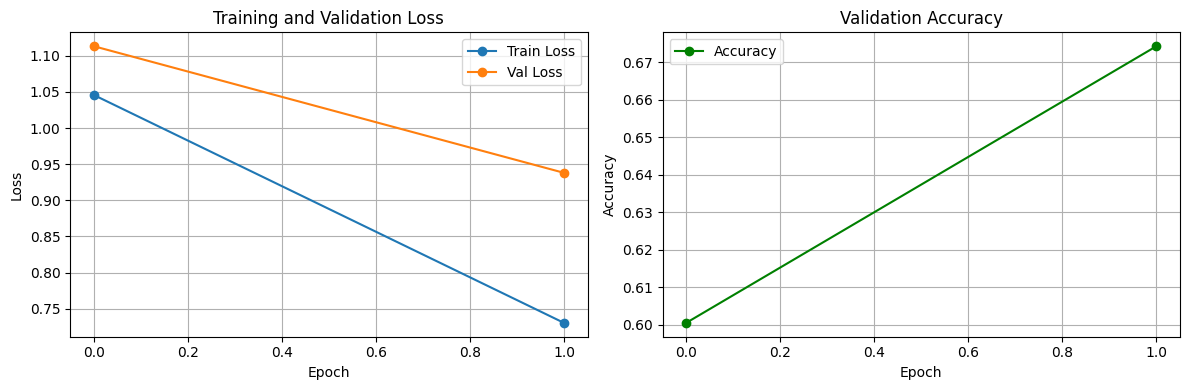

In [17]:
# Load and display training data from JSON
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

# Find the latest JSON file
log_dir = Path('./logs')
if log_dir.exists():
    json_files = sorted(log_dir.glob('training_log_*.json'))
    if json_files:
        latest_file = json_files[-1]
        
        # Load JSON data
        with open(latest_file, 'r') as f:
            training_data = json.load(f)
        
        print(f"📂 Loaded: {latest_file.name}")
        print(f"\n{'='*70}")
        print(f"{'TRAINING SUMMARY':^70}")
        print(f"{'='*70}")
        
        summary = training_data['summary']
        print(f"Timestamp:        {summary['timestamp']}")
        print(f"Total Epochs:     {summary['total_epochs']}")
        print(f"Best Accuracy:    {summary['best_accuracy']:.4f} (Epoch {summary['best_epoch']})")
        print(f"Final Train Loss: {summary['final_train_loss']:.4f}")
        print(f"Final Val Loss:   {summary['final_val_loss']:.4f}")
        print(f"{'='*70}\n")
        
        # Create DataFrame from epoch metrics
        metrics_df = pd.DataFrame(training_data['epochs'])
        print("Epoch Metrics:")
        print(metrics_df.to_string(index=False))
        
        # Plot metrics
        if len(metrics_df) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            
            axes[0].plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss', marker='o')
            axes[0].plot(metrics_df['epoch'], metrics_df['val_loss'], label='Val Loss', marker='o')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].set_title('Training and Validation Loss')
            axes[0].legend()
            axes[0].grid(True)
            
            axes[1].plot(metrics_df['epoch'], metrics_df['accuracy'], label='Accuracy', marker='o', color='green')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title('Validation Accuracy')
            axes[1].legend()
            axes[1].grid(True)
            
            plt.tight_layout()
            plt.show()
    else:
        print("No training log files found. Run training first!")
else:
    print("Logs directory not found. Run training first!")

In [ ]:
# Visualize misclassified images from JSON
import json
from pathlib import Path
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

log_dir = Path('./logs')
if log_dir.exists():
    json_files = sorted(log_dir.glob('training_log_*.json'))
    if json_files:
        latest_file = json_files[-1]
        
        with open(latest_file, 'r') as f:
            training_data = json.load(f)
        
        misclassified = training_data.get('misclassified_samples', [])
        
        if misclassified:
            print(f"Found {len(misclassified)} misclassified samples")
            
            # Display first 12 misclassified images
            num_display = min(12, len(misclassified))
            fig, axes = plt.subplots(3, 4, figsize=(15, 10))
            axes = axes.flatten()
            
            for idx in range(num_display):
                sample = misclassified[idx]
                
                # Decode base64 image
                img_data = base64.b64decode(sample['image_base64'])
                img = Image.open(BytesIO(img_data))
                
                true_label = sample['true_label']
                pred_label = sample['predicted_label']
                epoch = sample['epoch']
                
                # Display image
                axes[idx].imshow(img)
                axes[idx].set_title(f"Epoch {epoch}\nTrue: {true_label}, Pred: {pred_label}", 
                                   color='red' if true_label != pred_label else 'green')
                axes[idx].axis('off')
            
            # Hide unused subplots
            for idx in range(num_display, len(axes)):
                axes[idx].axis('off')
            
            plt.suptitle(f'Misclassified Images (showing {num_display}/{len(misclassified)})', fontsize=14)
            plt.tight_layout()
            plt.show()
            
            # Print summary
            print(f"\n📊 Misclassified Summary:")
            for idx, sample in enumerate(misclassified[:5]):
                print(f"  Sample {idx+1}: Epoch {sample['epoch']}, True Label: {sample['true_label']}, Predicted: {sample['predicted_label']}")
            if len(misclassified) > 5:
                print(f"  ... and {len(misclassified) - 5} more samples")
        else:
            print("No misclassified samples found")
    else:
        print("No training log files found")
else:
    print("Logs directory not found")